We start by simulating a 1-D lattice (representing a string)

$F_{ij} = \frac{k\Delta z(r - r_0)}{r}$, $\Delta z = z_j - z_i$, $r = \sqrt{\Delta z^2 + d^2}$

$m_i \ddot z_i = -F_{(i-1)i} + F_{i(i+1)}$, $z_0 = 0$, $z_{N-1} = 0$

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from manim import *
from dataclasses import dataclass

In [171]:
@dataclass
class Params():
    N: int = 103          # Number of masses
    m: float = .01      # Mass of each mass (kg)
    k: float = 100.     # Spring constant (N/m)
    r_0: float = 0.1    # Spring equilibrium distance (m)
    d: float = 1.      # In-plane distance between adjacent masses (m)
    t_max: float = 40.0     # Total time to simulate (s)
    dt: float = 0.001    # Time step (s)

class String():
    
    """
    N = number of masses in the system
    m = mass of each mass
    r_0 = spring equilibrium distance
    d = in-plane distance between adjacent masses
    """
    def __init__(self, p: Params):
        self.N = p.N
        self.m = p.m
        self.k = p.k
        self.r_0 = p.r_0
        self.d = p.d
    
    def dy_dt(self, t, z_arr):

        z = z_arr[:self.N]
        z_dot = z_arr[self.N:]

        z_ddot = np.zeros(self.N)
        
        #Boundary conditions: fixed ends
        z_ddot[0] = 0
        z_ddot[-1] = 0

        for i in range(1, self.N - 1):
            #z_ddot[i] = (self.k / self.m) * (z[i+1] - 2 * z[i] + z[i-1])
            r_1 = np.sqrt(self.d**2 + (z[i+1] - z[i])**2)
            r_2 = np.sqrt(self.d**2 + (z[i] - z[i-1])**2)
            F_1 = self.k * (r_1 - self.r_0) * (z[i+1] - z[i]) / r_1
            F_2 = self.k * (r_2 - self.r_0) * (z[i] - z[i-1]) / r_2
            z_ddot[i] = (F_1 - F_2) / self.m

        return np.concatenate((z_dot, z_ddot))
    
    def solve_ode(self, t_pts, z_0, z_dot_0, 
                  abserr=1.0e-10, relerr=1.0e-10):
        """
        Solve the ODE given initial conditions.
        For now use odeint, but we have the option to switch.
        Specify smaller abserr and relerr to get more precision.
        """
        z_arr = np.concatenate((z_0, z_dot_0)) 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             z_arr, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        return solution.y

In [172]:
# Create String instance
params = Params()

def delta_pluck(magnitude=1):
    z_0 = np.zeros(params.N)
    z_0[params.N // 2] = magnitude  # Pluck the middle mass upwards by 0.5 m
    z_dot_0 = np.zeros(params.N)
    return z_0, z_dot_0

def triangle_pluck(magnitude=1):
    z_0 = np.zeros(params.N)
    mid = params.N // 2
    for i in range(mid):
        z_0[i] = (magnitude / mid) * i
        z_0[params.N - 1 - i] = (magnitude / mid) * i
    if (params.N % 2) == 1: # odd case
        z_0[mid] = magnitude
    z_dot_0 = np.zeros(params.N)
    return z_0, z_dot_0

def random_pluck(magnitude=1):
    z_0 = magnitude * np.random.uniform(-1, 1, params.N)
    z_dot_0 = np.zeros(params.N)
    return z_0, z_dot_0

def solve_system(params, z_0, z_dot_0):
    string = String(params)

    t_pts = np.arange(0, params.t_max, params.dt)
    solution = string.solve_ode(t_pts, z_0, z_dot_0)
    return t_pts, solution

z_0, z_dot_0 = random_pluck(magnitude=1)

t_pts, sol = solve_system(params, z_0, z_dot_0)
z = sol[:params.N, :]
z_dot = sol[params.N:, :]

# Plot results
"""
fig, ax = plt.subplots(params.N, 1, figsize=(10, 2*params.N))

for i in range(params.N):
    ax[i].plot(t_pts, z[i, :])
    ax[i].set_title(f'Mass {i+1} Displacement Over Time')
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Displacement')
"""

"\nfig, ax = plt.subplots(params.N, 1, figsize=(10, 2*params.N))\n\nfor i in range(params.N):\n    ax[i].plot(t_pts, z[i, :])\n    ax[i].set_title(f'Mass {i+1} Displacement Over Time')\n    ax[i].set_xlabel('Time')\n    ax[i].set_ylabel('Displacement')\n"

In [161]:
# -------------------------------
# Simple spring helper (zig-zag)
# -------------------------------
def spring_polyline(start, end, coils=6, amplitude=0.25, inset=0.35):
    """
    Returns a VMobject shaped like a planar coil spring from start -> end.
    Uses set_points_as_corners for a crisp zig-zag. Compatible with manim v0.19.
    """
    start = np.array(start, dtype=float)
    end   = np.array(end, dtype=float)
    vec = end - start
    L = np.linalg.norm(vec)
    if L < 1e-6:
        return Line(start, end, stroke_width=6)

    # Local frame
    xhat = vec / L
    up = np.array([0.0, 1.0, 0.0])
    yhat = up - np.dot(up, xhat) * xhat
    ny = np.linalg.norm(yhat)
    if ny < 1e-8:
        right = np.array([1.0, 0.0, 0.0])
        yhat = right - np.dot(right, xhat) * xhat
        yhat /= np.linalg.norm(yhat)
    else:
        yhat /= ny

    # Straight end segments + zig-zag body
    Lz = max(L - 2 * inset, 0.0)
    n_verts = 2 * coils + 1
    xs = np.linspace(inset, inset + Lz, n_verts)

    ys = np.zeros_like(xs)
    ys[1::2] =  amplitude
    ys[2::2] = -amplitude
    # Ensure the last zig-zag point is on the center line
    if n_verts > 0:
        ys[-1] = 0

    pts = [start, start + xhat * inset]
    for xi, yi in zip(xs, ys):
        pts.append(start + xhat * xi + yhat * yi)
    pts += [end - xhat * inset, end]

    pts = np.array(pts, dtype=float)

    spring = VMobject()
    spring.set_points_as_corners(pts)
    spring.set_stroke(width=6)
    spring.set_fill(opacity=0)
    return spring

In [138]:
# -------------------------------
# Manim Scene
# -------------------------------
class String1D(Scene):
    def construct(self):

        # Create the main title
        title = Text(f"1-D Spring Lattice", font_size=38).to_edge(UP)

        # Create the subtitle with spring constants
        subtitle = Tex(
            rf"$m={params.m}$, $k={params.k}$, $r_0={params.r_0}$, $d={params.d}$",
            font_size=32,
            color=WHITE
        ).next_to(title, DOWN)

        self.add(title, subtitle)

        # Interpolators for animation time -> displacement
        def z_of(t, i):
            return np.interp(t, t_pts, z[i])


        # Mass blocks (centered vertically, move along x only)
        span = 6

        #Fixed walls
        left_wall  = Rectangle(width=0.25, height=3.5).move_to(LEFT*span)
        right_wall = Rectangle(width=0.25, height=3.5).move_to(RIGHT*span)
        left_wall.set_fill(GREY, opacity=1.0).set_stroke(width=0)
        right_wall.set_fill(GREY, opacity=1.0).set_stroke(width=0)

        self.add(left_wall, right_wall)

        mass_dim = span / 2 / params.N
        masses = np.zeros(params.N, dtype=object)
        x_eq = np.linspace(-span, span, params.N)
        masses[0] = None
        masses[-1] = None
        for i in range(1, params.N-1):
            z_init = z_of(0, i)

            masses[i] = Rectangle(width=mass_dim, height=mass_dim, color=BLUE, fill_opacity=1.0)
            masses[i].move_to([x_eq[i], z_init, 0.0])
            self.add(masses[i])

        # Time tracker (drives the animation 1:1 with real time)
        t_tracker = ValueTracker(0.0)

        # Updaters for the masses (position vs. t)
        def mass_updater(mob, i):
            t = t_tracker.get_value()
            z = z_of(t, i)
            mob.move_to([x_eq[i], z, 0.0])


        for i in range(1, params.N-1):
            masses[i].add_updater(lambda mob, i=i: mass_updater(mob, i))

        # Use always_redraw so geometry refreshes as the masses move.
        springs = np.zeros(params.N - 1, dtype=object)

        # Create springs by binding the left/right mass objects at definition time
        for i in range(0, params.N - 1):
            num_coils = 3

            if i == 0:
                start_obj = left_wall
            else:
                start_obj = masses[i]
            
            if i == params.N - 2:
                end_obj = right_wall
            else:
                end_obj = masses[i+1]

            # Create a concrete spring VMobject and add a manual updater
            start = start_obj.get_right()
            end = end_obj.get_left()
            spr = spring_polyline(start, end, coils=num_coils, amplitude=mass_dim / 2, inset=mass_dim / 2).set_color(WHITE)

            def spr_updater(s, start_obj=start_obj, end_obj=end_obj):
                start = start_obj.get_right()
                end = end_obj.get_left()
                new = spring_polyline(start, end, coils=num_coils, amplitude=mass_dim / 2, inset=mass_dim / 2).set_color(WHITE)
                s.become(new)

            spr.add_updater(spr_updater)
            springs[i] = spr
            self.add(spr)

        # Optional: show a running time readout
        time_readout = DecimalNumber(
            number=0.0, num_decimal_places=2, include_sign=False
        ).set_font_size(28).to_corner(UR).shift(LEFT*1.1 + DOWN*1.5)
        time_label = Text("t (s) =", font_size=28).next_to(time_readout, LEFT, buff=0.2)

        def time_updater(mob):
            mob.set_value(t_tracker.get_value())

        time_readout.add_updater(time_updater)
        self.add(time_label, time_readout)

        # Animate: advance the tracker from 0 -> T_total in real time (rate_func=linear)
        self.play(t_tracker.animate.set_value(params.t_max), run_time=params.t_max, rate_func=linear)

        # Hold last frame briefly
        self.wait(0.5)


In [139]:
%manim -pql String1D

Manim Community v0.19.1

C:\Users\antho\AppData\Local\Temp\ipykernel_48480\64310969.py:95: DeprecationWarning: This method is not guaranteed to stay around. Please prefer setting the attribute normally or with Mobject.set().
  ).set_font_size(28).to_corner(UR).shift(LEFT*1.1 + DOWN*1.5)


KeyboardInterrupt: 

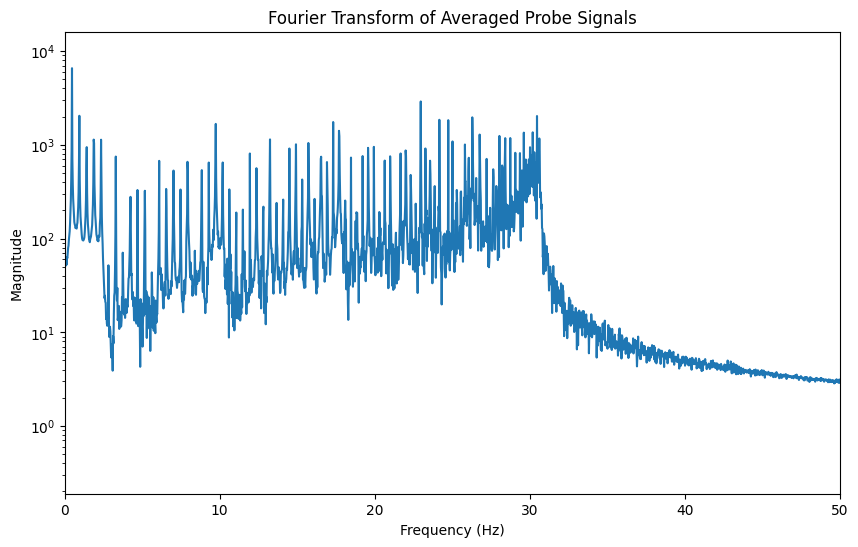

In [175]:
# Calculate harmonics using probes at corner, 1/3, and center masses

probe_indices = [1, params.N // 3, params.N // 2]

# Fourier Transform of GMS
freqs = np.fft.rfftfreq(len(t_pts), d=params.dt)

avg_spectrum = np.zeros(len(freqs))

for idx in probe_indices:
    probe_signal = z[idx, :]
    
    # Fourier Transform
    probe_fft = np.abs(np.fft.rfft(probe_signal))
    
    avg_spectrum += probe_fft

avg_spectrum /= len(probe_indices)

fig_mag, ax_mag = plt.subplots(figsize=(10, 6))
ax_mag.semilogy(freqs, avg_spectrum)
ax_mag.set_title('Fourier Transform of Averaged Probe Signals')
ax_mag.set_xlabel('Frequency (Hz)')
ax_mag.set_ylabel('Magnitude')
ax_mag.set_xlim(0, 50)

plt.show()

In [180]:
# Determine peak frequencies
from scipy.signal import find_peaks

peaks, _ = find_peaks(avg_spectrum, height=150)

peak_freqs = freqs[peaks]
peak_amps = avg_spectrum[peaks]

# Theoretical fundamental frequency
k_eff = params.k * (1 - params.r_0 / params.d)
f1 = 1/np.pi * np.sqrt(params.k / params.m) * np.sin(np.pi / (2 * (params.N - 1)))

# Print peak frequencies and amplitudes
if len(peak_freqs) > 0:
    print(f"Fundamental Frequency (f1): {f1:.4f} Hz")
    print("-" * 40)
    print(f"{'Peak (Hz)':<12} | {'Amplitude':<10} | {'Ratio (f/f1)':<12}")
    print("-" * 40)

    for f, amp in zip(peak_freqs, peak_amps):
        ratio = f / f1

        print(f"{f:<12.4f} | {amp:<10.4f} | {ratio:<12.4f}")
else:
    print("No peaks found!")

Fundamental Frequency (f1): 0.4902 Hz
----------------------------------------
Peak (Hz)    | Amplitude  | Ratio (f/f1)
----------------------------------------
0.4750       | 6561.4656  | 0.9690      
0.9500       | 2038.7312  | 1.9381      
1.4250       | 943.7089   | 2.9071      
1.8750       | 1135.8431  | 3.8252      
2.3500       | 1132.7719  | 4.7942      
3.3000       | 748.4756   | 6.7323      
4.2500       | 278.3050   | 8.6703      
4.7000       | 329.2495   | 9.5884      
5.1750       | 323.1900   | 10.5574     
6.1000       | 673.6845   | 12.4445     
6.5500       | 337.8890   | 13.3625     
7.0250       | 530.7540   | 14.3316     
7.4750       | 333.2611   | 15.2496     
7.9250       | 658.0633   | 16.1676     
8.8500       | 536.4338   | 18.0547     
9.3000       | 646.3480   | 18.9727     
9.7500       | 1669.6159  | 19.8908     
10.2000      | 647.1189   | 20.8088     
10.6250      | 334.1119   | 21.6759     
11.0750      | 189.2156   | 22.5939     
11.5000      | 203.